# Make an Antarctic Rift Catalog

## Step 0: Decide which data to use
This is done using IcePyx to spatially window available data

In [4]:
shelf_name = 'brunt'

# Format is WSNE
spatial_extent = [-27.8, -76.1, -3.0, -70.2] # Brunt-Riiser-Ekstrom System
# spatial_extent = [-3.0,-71.5, 39.5, -68.6] # Fimbul
# spatial_extent = [67.6, -72.44,74.87,-68.39] # Amery
# spatial_extent = [159, -86, 180, -69] # East Ross
# spatial_extent = [-180, -86, -140, -77] # West Ross
# spatial_extent = [-65.5,-68.7,-60.2,-66] # Larsen C
# spatial_extent = [-82.0, 82.4, -79.5, 82.9] # Milne

In [5]:
# If filelist_file_name exists, then load it.  Otherwise query icepyx

file_path = 's3://its-live-data.jpl.nasa.gov/icesat2/alt06/rel003/'
# file_path = '/Users/lipovsky/is2-data/' + shelf_name + '/'

import os.path
import h5py
import pickle

filelist_file_name = shelf_name + '_filelist.pickle'
if os.path.isfile(filelist_file_name):
    with open(filelist_file_name, 'rb') as handle:
        file_list = pickle.load(handle)
else:       
    import icepyx as ipx
    date_range = ['2018-10-14','2020-12-01']
    region_a = ipx.Query('ATL06', spatial_extent, date_range)
    granules=region_a.granules.avail

    file_list = []
    for f in granules: 
        file_list.append(file_path + f['producer_granule_id'])
        
    with open(filelist_file_name, 'wb') as handle:
        pickle.dump(file_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print('Filelist written with %d files in it.'%len(file_list))

## Step 1. Read the ATL06 files into a Python data structure
Put the needed info in a dictionary, save the whole thing to file.

In [6]:
import arc
import numpy as np
import importlib
importlib.reload(arc)

atl06_file_name = shelf_name + '_atl06.pickle'
# maskfile = '/Users/lipovsky/Downloads/BedMachineAntarctica_2020-07-15_v02.nc'
maskfile = 'BedMachineAntarctica_2020-07-15_v02.nc'

if os.path.isfile(atl06_file_name):
    print('Data already pickled, so theres no need to ingest data. \
To repeat the data ingest, it would probably be best to change the filename of the \
existing pickle file.')
else:
    arc.ingest(file_list,atl06_file_name,maskfile)

Data already pickled, so theres no need to ingest data. To repeat the data ingest, it would probably be best to change the filename of the existing pickle file.


## Step 2.  Run the rift detector

In [12]:
# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)

# for i in range(len(atl06_data['quality'])):
#     atl06_data['quality'][i] = np.array(atl06_data['quality'][i])
#     atl06_data['h'][i] = np.array(atl06_data['h'][i])
#     atl06_data['geoid'][i] = np.array(atl06_data['geoid'][i])
#     atl06_data['azimuth'][i] = np.array(atl06_data['azimuth'][i])
#     atl06_data['h_sig'][i] = np.array(atl06_data['h_sig'][i])


# Find the rifts
rift_obs = arc.get_rifts(atl06_data)

# Store the rifts in a dataframe
import pandas as pd
import geopandas
rift_obs=pd.DataFrame(rift_obs)
rift_obs = geopandas.GeoDataFrame(rift_obs,
                             geometry=geopandas.points_from_xy(rift_obs['x-centroid'],
                                                               rift_obs['y-centroid']))

/home/ec2-user/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


 
Found 14914 rifts.
Time to detect rifts: 63.29406063699571


## Step 3. Plot the rifts on imagery 

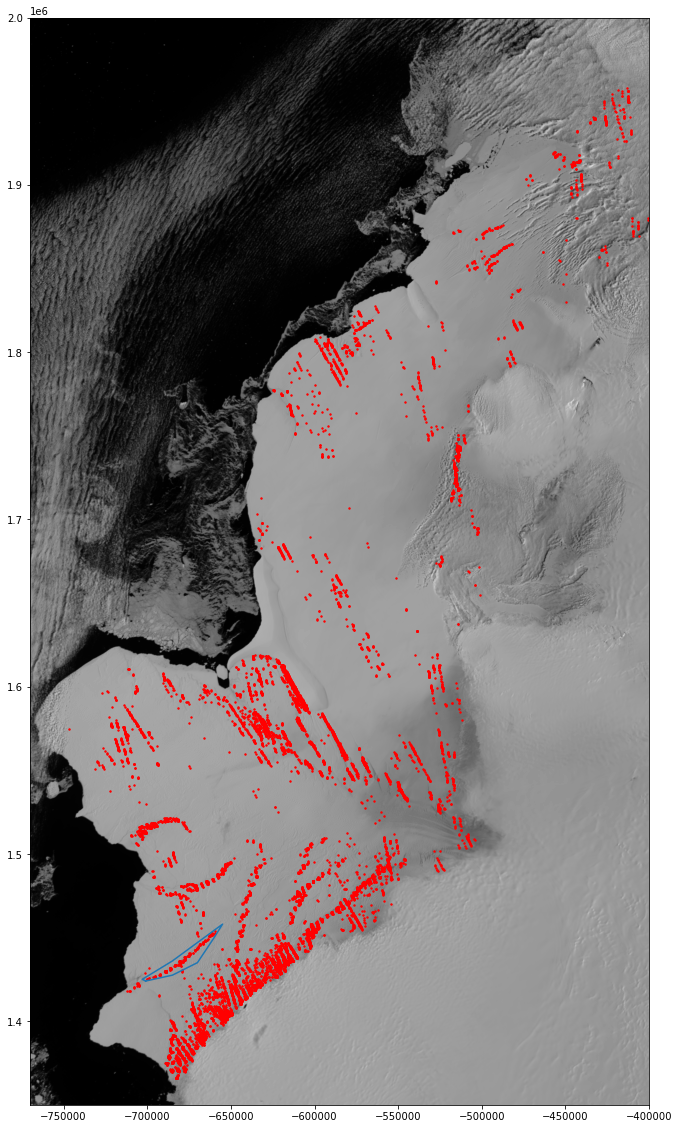

In [38]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.colors as colors

image_file = 'riise_2020028_1615_modis_ch02.tif'
# image_file = '/Users/lipovsky/Downloads/riise_2020028_1615_modis_ch02.tif'

# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax2)
ax2.scatter(rift_obs['x-centroid'] ,rift_obs['y-centroid'] ,s=2,c='r')

# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]

# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]

plt.ylim(window_y)
plt.xlim(window_x)



# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy
plt.plot(box_x,box_y)
plt.show()

## Step 4.  Load ITS_LIVE velocities

In [39]:
from netCDF4 import Dataset    
# d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
d = Dataset('ANT_G0120_0000.nc', 'r')
# print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)





# Calculate strains

dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


## Step 5. Plot just the Halloween crack  against the ITS_LIVE velocities

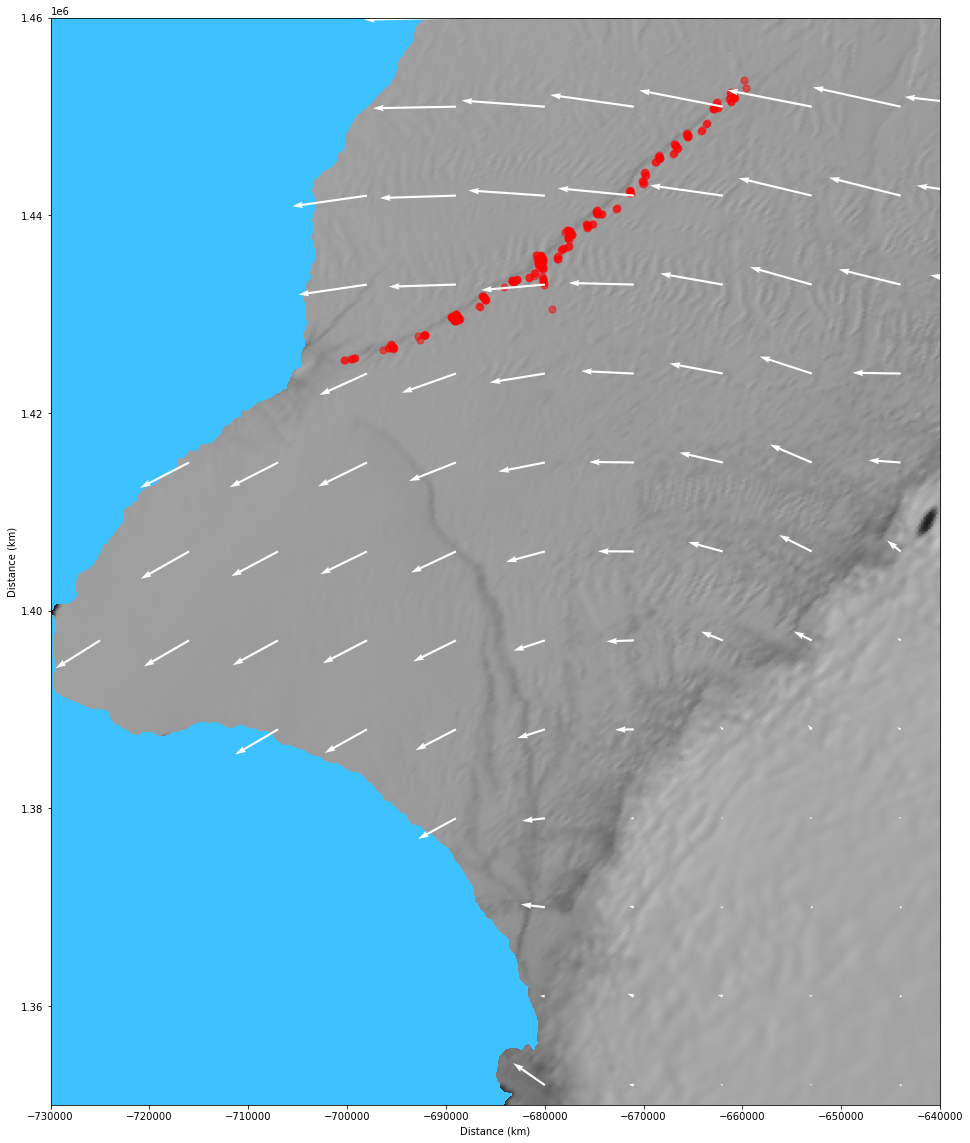

In [40]:
from matplotlib import cm
fig3,ax3=plt.subplots(figsize=(20,20))

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))
show(sat_data,cmap="gray",ax=ax3)
c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [44]:
from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( 'halloween.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)

FileNotFoundError: [Errno 2] No such file or directory: 'halloween.pickle'

# "Kalman Filter" (not really)
At each time-step: 1) add new observations, 2) update old observations, 3) merge observations if they are close enough


In [ ]:
# This version uses pandas in all its glory

time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for t,i in zip(time_vector,np.arange(len(time_vector))):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y']).diagonal()
        vy_new = vy_interp(state_vector['x'],state_vector['y']).diagonal()
        
        # Calculate strain rates
        e11 = vx_x(state_vector['x'],state_vector['y']).diagonal()
        e12 = ( vx_y(state_vector['x'],state_vector['y']).diagonal() 
              + vy_x(state_vector['x'],state_vector['y']).diagonal() ) / 2
        e22 = vy_y(state_vector['x'],state_vector['y']).diagonal()
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

In [ ]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlim((-694,-691))
plt.ylim((1426,1429))
plt.show()

In [ ]:
fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(6,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
plt.show()

# Plot a snapshot

In [ ]:
fig10,ax10 = plt.subplots(figsize=(15,15))
item = list_of_state_vectors[40]

color=iter(cm.viridis(np.linspace(0,1,len(time_vector))))
for t in time_vector:
    c=next(color)
    plt.scatter(item[item['t']==t]['x']/1e3,
                item[item['t']==t]['y']/1e3,
                color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.axis('image')
plt.xlim((-705,-660))
plt.ylim((1425,1455))
plt.show()

# How close are rift observations?

In [ ]:
hist, bins, _ = plt.hist(seperation_list, bins=20)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.clf()
fig8 = plt.subplots()
plt.hist(seperation_list, bins=logbins)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Nearest Neighbor Distance (cumulative over all time steps)')
plt.ylabel('Count')
plt.grid()
plt.rcParams.update({'font.size': 15})
plt.show()

# How does rift width vary?

In [ ]:
latest = list_of_state_vectors[-1]

xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )
fig12 = plt.subplots(figsize=(15,5))
c=plt.scatter(dist/1e3,latest['w'],c=times,label=latest['t'])
xx = np.arange(0,46,0.01)
plt.plot(xx,800*np.sqrt(46**2 - xx**2)/45,'-r')
cbar=plt.colorbar(c)
cbar.set_label('Days since first observation')
plt.xlabel('Distance along rift (km)')
plt.ylabel('Rift width (m)')
plt.grid()
plt.show()

# How different are expected-versus-actual rift widths?